# Lab 7: Twitter data analysis  

In this lab, we will learn how to read JSON files and how to perform exploratory analysis of twitter data. As an extra credit, you will learn how to use API to download tweets on the topic of your choice.

Let us start by importing the needed packages.

In [2]:
import json
import random
import time
import calendar
import codecs
import datetime
import sys
import gzip
import string
import glob
import os
import numpy as np
import dateutil.parser

## Module 0: Reading Tweets

Tweets are saved in the form of a JSON file. Open `onetweet` file in a text editor and study how it looks. This file contains information from a single tweet. The file is written in the JSON format, which is easy for a computer to read and parse. 

**Question 1**. Google `JSON` and try to learn about this particular data format. Explain in one or two paragraphs what you learned.

Let us read `onetweet` JSON file. We will create an object and print it.

**Answer 1** : JSON stands for JavaScript Object Notation. It is syntax for storing and exchanging data. It is easy for humans to read and write. It is easy for machines to parse and generate. It is based on a subset of the JavaScript Programming Language, Standard ECMA-262 3rd Edition - December 1999. JSON is a text format that is completely language independent.
JSON is built on two structures: A collection of name/value pairs. In various languages, this is realized as an object, record, struct, dictionary, hash table, keyed list, or associative array. An ordered list of values. In most languages, this is realized as an array, vector, list, or sequence.

In [3]:
from pprint import pprint
# tweet = json.load(open('onetweet', 'rb').decode('utf8'))
with open('onetweet.json') as f:
    tweet = json.load(f)
pprint(tweet)

{u'_id': u'264230205529411585',
 u'contributors': None,
 u'coordinates': {u'coordinates': [-73.95639896, 40.71411847],
                  u'type': u'Point'},
 u'created_at': u'2012-11-02T04:59:24',
 u'disaster': u'2012_sandy_hurricane_en',
 u'entities': {u'hashtags': [],
               u'symbols': [],
               u'urls': [{u'display_url': u'instagr.am/p/Rg70o6xlkY/',
                          u'expanded_url': u'http://instagr.am/p/Rg70o6xlkY/',
                          u'indices': [33, 53],
                          u'url': u'http://t.co/G0LdsQAz'}],
               u'user_mentions': []},
 u'favorite_count': 0,
 u'favorited': False,
 u'geo': {u'coordinates': [40.71411847, -73.95639896], u'type': u'Point'},
 u'id': u'264230205529411585',
 u'id_str': u'264230205529411585',
 u'in_reply_to_screen_name': None,
 u'in_reply_to_status_id': None,
 u'in_reply_to_status_id_str': None,
 u'in_reply_to_user_id': None,
 u'in_reply_to_user_id_str': None,
 u'is_quote_status': False,
 u'lang': u'en',

As we can see, each tweet is stored in a dictionary. Although there are more than 20 different keys in the dictionary, we introduce the most important fields which will be used in the rest of this lab.
<ul>
<li>'_id': shows the unique id of this tweet.</li>

<li>'coordinates': shows the location from which the tweet was posted. The field might be null if the tweet contains no location data, or it could contain bounding box information, place information, or GPS coordinates in the form of (longitude, latitude). </li>

<li>'created_at': shows the time the tweet has been created.</li>

<li>'text': shows the text of the tweet.</li>

<li>'user': contains multiple dictionaries describing the user, including the name of this user, the number of followers, the number of friends...</li>
</ul>

**Question 2**. Explain 3 more keys that you find interesting

* 'place' contains details such as the coordinates of the tweet and also includes country and city
* 'retweet_count' gives the number of retweets a particular tweet had
* 'text' gives the raw text that the user wrote in their tweet

In the following code we will load around 4,000 tweets sent from New York City region during Sandy Hurricane from a JSON file `myNYC.json`. As part of this process, we will extract each tweet's post time and create a time series of the number of tweets in each hour during the event.

In [4]:
filePath='smallNYC.json'
localTweetList = []
globalTweetCounter = 0
frequencyMap = {}
timeFormat = "%a %b %d %H:%M:%S +0000 %Y"
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    
    # Try to extract the time of the tweet
    currentTime=dateutil.parser.parse(tweetObj['created_at'])
    currentTime = currentTime.replace(second=0)
    currentTime = currentTime.replace(minute=0)

    # print(currentTime)
    # Increment tweet count
    globalTweetCounter += 1
    
    # If our frequency map already has this time, use it, otherwise add
    if currentTime in frequencyMap.keys():
        timeMap = frequencyMap[currentTime]
        timeMap["count"] += 1
        timeMap["list"].append(tweetObj)
    else:
        frequencyMap[currentTime] = {"count":1, "list":[tweetObj]}

# Fill in any gaps
times = sorted(frequencyMap.keys())
firstTime = times[0]
lastTime = times[-1]
thisTime = firstTime

#timeIntervalStep = datetime.timedelta(0, 60)    # Time step in seconds
timeIntervalStep = datetime.timedelta(hours=1)
while ( thisTime <= lastTime ):
    if ( thisTime not in frequencyMap.keys() ):
        frequencyMap[thisTime] = {"count":0, "list":[]}
        
    thisTime = thisTime + timeIntervalStep

print ("Processed Tweet Count:", globalTweetCounter)

('Processed Tweet Count:', 4295)


## Module 1: Simple Frequency Analysis

In this section, we will cover a few simple analysis techniques for EDA of the available twitter data.

- Twitter Timeline
- Top Twitter Users
- Twitter API
- Posting Frequency Distribution
- Popular Hashtags
- Simple Event Detection
- Language Distributions

### Twitter Timeline 

To build a timeline of Twitter usage, we can simply plot the number of tweets posted per hour.

('Time Frame:', datetime.datetime(2012, 10, 22, 5, 0), datetime.datetime(2012, 11, 2, 4, 0))


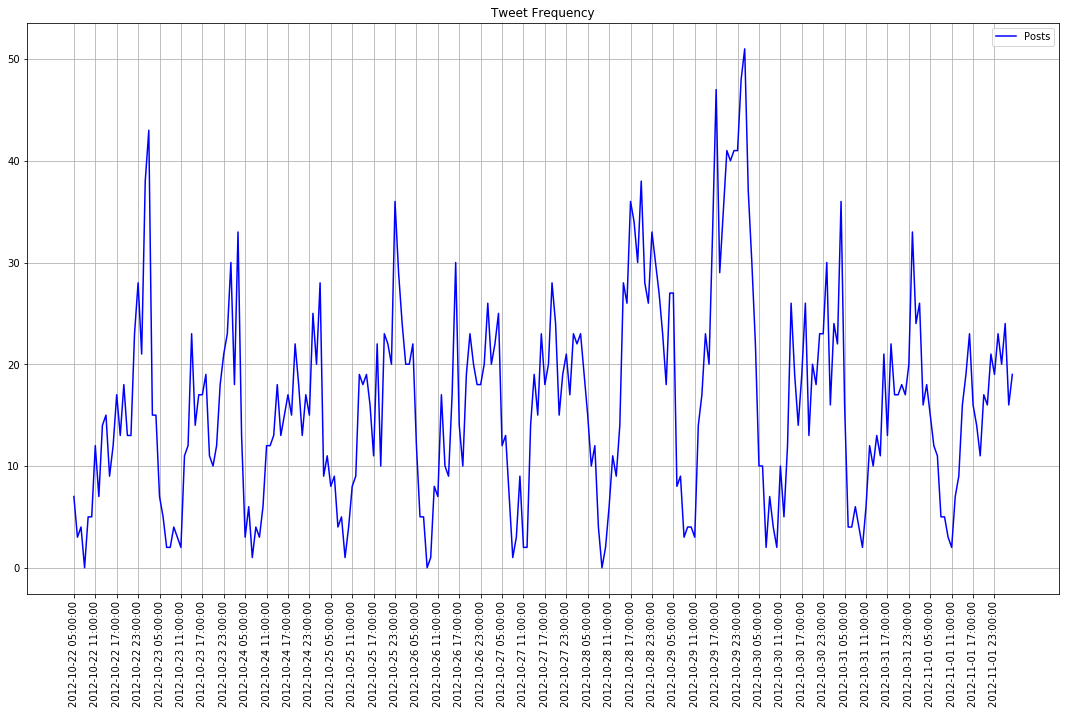

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")

# Sort the times into an array for future use
sortedTimes = sorted(frequencyMap.keys())

# What time span do these tweets cover?
print ("Time Frame:", sortedTimes[0], sortedTimes[-1])

# Get a count of tweets per minute
postFreqList = [frequencyMap[x]["count"] for x in sortedTimes]

# We'll have ticks every thirty minutes (much more clutters the graph)
smallerXTicks = range(0, len(sortedTimes), 6)
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# Plot the post frequency
ax.plot(range(len(frequencyMap)), [x if x > 0 else 0 for x in postFreqList], color="blue", label="Posts")
ax.grid(b=True, which=u'major')
ax.legend()

plt.show()

**Question 3**. When is the tweeting activity the largest? Find a wikipedia article about the Sandy Hurricane to understand the timeline of events surrounding it. Discuss if you see a correlation with the tweet frequencies. Select some tweets from different time points and see if the messages are correlated with the events on the ground.

Sandy developed from a tropical wave in the western Caribbean Sea on October 22, quickly strengthened, and was upgraded to Tropical Storm Sandy six hours later. Tweets about Sandy started on October 22 at 5:00, and at 23:00 on the same day, number of tweets peaked at over 40 (the third highest peak of Sandy tweets).

Early on October 29, Sandy curved west-northwes and then moved ashore near Brigantine, New Jersey, just to the northeast of Atlantic City, as a post-tropical cyclone with hurricane-force winds. As we can see in the graph, tweets about Sandy in NY hit the two highest peak latter on the day of October 29 and early October 30, when Sandy was about to reach New Jersey, close to NY

In [7]:
max(frequencyMap, key = lambda x: frequencyMap[x])

datetime.datetime(2012, 10, 30, 1, 0)

In [8]:
d = sorted(frequencyMap.values(), reverse = True)[:6]
for t in d:
    posts = random.sample(t['list'], 5) 
    for p in posts:
        print('posted ', p['created_at'], 'user ', p['user']['name'], 'text ', p['text'])

('posted ', u'2012-10-30T01:11:32', 'user ', u'Arnellee', 'text ', u'Lmao dead! RT"@LuztotheMary: I\'m gonna go to school on Wednesday looking like a cow, and I\'m not talking Halloween costume."')
('posted ', u'2012-10-30T01:17:24', 'user ', u'caroline', 'text ', u'http://t.co/7XZGjnPm')
('posted ', u'2012-10-30T01:49:02', 'user ', u'chau williams', 'text ', u'BGC cbk shout out to\u2026 @laneyalenhart @alishiamsarabia @shamekazsmassey @margitylnfrank really nice of you')
('posted ', u'2012-10-30T01:21:08', 'user ', u'Greg Stefano', 'text ', u'#blackout')
('posted ', u'2012-10-30T01:52:02', 'user ', u'Hajdi Manellari', 'text ', u'I actually just want to be with you right now lol')
('posted ', u'2012-10-30T00:54:32', 'user ', u'Bernadette Kelly', 'text ', u'Fire escape. Weirdly calm despite power outage. #sandy http://t.co/ErkfXND0')
('posted ', u'2012-10-30T00:09:08', 'user ', u'Jeff Yang', 'text ', u"@arunNYC Went to parents' place thinking higher ground was a good idea, but the wind'

### Top Twitter Users

The following piece of code reveals the users that produced the most tweets. 

In [9]:
# Create maps for holding counts and tweets for each user
globalUserCounter = {}
globalUserMap = {}

# Iterate through the time stamps
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # For each tweet, pull the screen name and add it to the list
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if user not in globalUserCounter:
            globalUserCounter[user] = 1
            globalUserMap[user] = [tweet]
        else:
            globalUserCounter[user] += 1
            globalUserMap[user].append(tweet)

print ("Unique Users:", len(globalUserCounter.keys()))

('Unique Users:', 3042)


In [10]:
sortedUsers = sorted(globalUserCounter, key=globalUserCounter.get, reverse=True)
print ("Top Ten Most Prolific Users:")
for u in sortedUsers[:10]:
    print (u, globalUserCounter[u], "\n\t", "Random Tweet:", globalUserMap[u][0]["text"], "\n----------")

Top Ten Most Prolific Users:
(u'Young_Boss718', 37, '\n\t', 'Random Tweet:', u'That random text  I had got be for LMFAO shit was funny', '\n----------')
(u'Cocky_Johnny', 15, '\n\t', 'Random Tweet:', u'@_tinaDeex3 LMAO #Dead', '\n----------')
(u'frankieciv608', 15, '\n\t', 'Random Tweet:', u'\u201c@JohnKincade Dear Donald Trump,\nAmericans &amp; Republicans chose to not involve you in this election between Prez &amp; Romney.\nPlease go away.\u201d', '\n----------')
(u'labroides', 14, '\n\t', 'Random Tweet:', u"@SharkDevocean best of luck. That's awesome", '\n----------')
(u'ReelTalker', 12, '\n\t', 'Random Tweet:', u'@FilmFatale_NYC also, in other news, i totally thought it was idris who tweeted me. Saw the pic and got  excited :-)', '\n----------')
(u'kcastrox3', 11, '\n\t', 'Random Tweet:', u'Cuz this love is a sure thing.', '\n----------')
(u'carolsommers727', 11, '\n\t', 'Random Tweet:', u'@coreymach lookin spiffy \U0001f44c', '\n----------')
(u'Amooniac', 11, '\n\t', 'Random Tweet

**Question 4**. Find and print the top 10 users with the most friends. Find and print the top 10 users with the most followers. 

In [11]:
friendsCounter = {}
followersCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        user = tweet["user"]["screen_name"]
        
        if user not in friendsCounter:
            friendsCounter[user] = tweet["user"]["friends_count"]

        if user not in followersCounter:
            followersCounter[user] = tweet["user"]["followers_count"]

In [12]:
sortedFriends = sorted(friendsCounter, key = friendsCounter.get, reverse = True)
sortedFollowers = sorted(followersCounter, key = followersCounter.get, reverse = True)

for user in sortedFriends[:10]:
    print "user ", user, " number of friends ", friendsCounter[user]

print '\n'

for user in sortedFollowers[:10]:
    print "user ", user, " number of followers ", followersCounter[user]

user  mstupenengo  number of friends  49501
user  GinsburgJobs  number of friends  49441
user  WeAreJocelyn  number of friends  37969
user  MrThugZilla2K15  number of friends  33902
user  davesurber  number of friends  29221
user  55_althani  number of friends  26414
user  EddieJMontanez  number of friends  21662
user  andrewcotto  number of friends  17312
user  MargaretMolloy  number of friends  16958
user  tupaclivesss  number of friends  11334


user  mstupenengo  number of followers  1162644
user  iJokes_  number of followers  185923
user  felixsalmon  number of followers  164709
user  EmersonOverton  number of followers  155045
user  umakhouny  number of followers  126453
user  AgramyQ8  number of followers  112323
user  55_althani  number of followers  94191
user  QueensMuseum  number of followers  80871
user  JosephWakile  number of followers  73103
user  Majovargas_  number of followers  67256


### Distribution of Postings

It appears a few users were posting to Twitter a lot. But how often did most Twitter users tweet during this time? We can build a histogram to see this distribution.


c:\users\inceptix\documents\github\cis-3715\python2\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


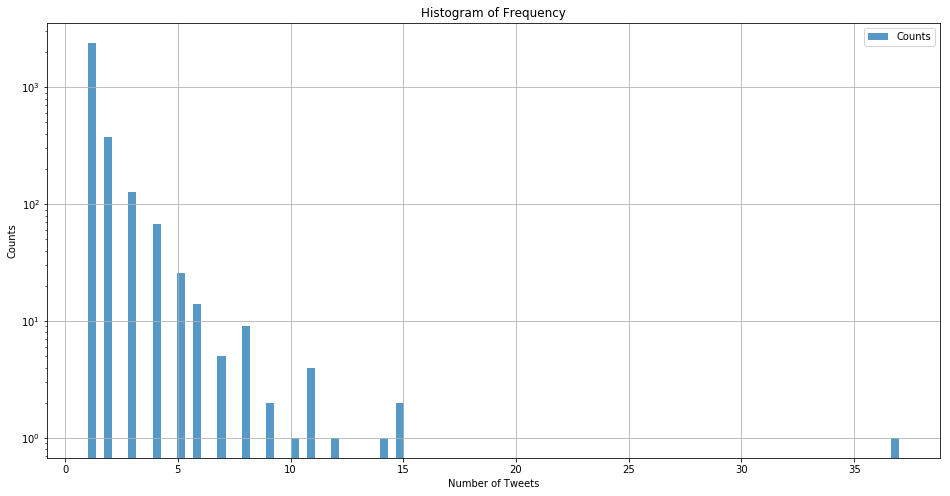

In [13]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.hist(
    [globalUserCounter[x] for x in globalUserCounter], 
    bins=100, 
    normed=0, 
    alpha=0.75,
    label="Counts",
    log=True)

plt.xlabel('Number of Tweets')
plt.ylabel('Counts')
plt.title("Histogram of Frequency")
plt.grid(True)
plt.legend()

plt.show()

**Question 5**. Study 3 users with the most posts. What were they tweeting about?

### Average Number of Posts

In [14]:
avgPostCount = np.mean([globalUserCounter[x] for x in globalUserCounter])
print("Average Number of Posts:", avgPostCount)

('Average Number of Posts:', 1.4119000657462195)


**Answer 5** :

In [15]:
top3 = sortedUsers[:3]
for u in top3:
    print "USER ", u
    for i in range(len(globalUserMap[u])):
        print globalUserMap[u][i]["text"]
    print "\n"

USER  Young_Boss718
That random text  I had got be for LMFAO shit was funny
@MeerGotGame don't try and find shit lol
U inbox her on fb or text her
That wax museum is a fool in New York shit be real af
I kinda just felt when she just said idgaf lol
We be on the loud shit
Y'all be smoking that low volume
@BossBitchShxt chill out Monae you know I fucks with fab lol
I got my list tho 🙈🙉🙊
@The_Good_Fella9 it's ok
@NOFcks_Givn gave that head to ?
PART2
@The_Good_Fella9 word she's cool af
i wonder who had crush on me on twitter 😜😝😛😵
White girls don't have butts LMFAO
@BricksFromPluto lol
@SugarCocaine_ well I heard mad down south ppl say it that's why I ask
Getting alil sleepy
Moms gone for the whole night shit just about to smoke &amp; kick it with da homies
@LiyahhDoeee I know that's not you in them heels and skirt
@MikeyGotBudd I fucks with the mishka shirt fam
@Loud_Everyday 💯 already know
@She_Suckedd nigga shut up 😒
The pic jaida just posted -_-
No more talking, let’s be about it
Sexcap

### Popular Hashtags

Hashtags give us a quick way to view the conversation and see what people are discussing. Getting the most popular hashtags is just as easy as getting the most prolific users.


In [16]:
# A map for hashtag counts
hashtagCounter = {}

# For each minute, pull the list of hashtags and add to the counter
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        hashtagList = tweet["entities"]["hashtags"]
        
        for hashtagObj in hashtagList:
            
            # We lowercase the hashtag to avoid duplicates (e.g., #MikeBrown vs. #mikebrown)
            hashtagString = hashtagObj["text"].lower()
            
            if ( hashtagString not in hashtagCounter ):
                hashtagCounter[hashtagString] = 1
            else:
                hashtagCounter[hashtagString] += 1

print ("Unique Hashtags:", len(hashtagCounter.keys()))
sortedHashtags = sorted(hashtagCounter, key=hashtagCounter.get, reverse=True)
print ("Top Twenty Hashtags:")
for ht in sortedHashtags[:20]:
    print ("\t", "#" + ht, hashtagCounter[ht])

('Unique Hashtags:', 997)
Top Twenty Hashtags:
('\t', u'#sandy', 108)
('\t', u'#nyc', 47)
('\t', u'#hurricanesandy', 26)
('\t', u'#newyork', 12)
('\t', u'#brooklyn', 9)
('\t', u'#hurricane', 8)
('\t', u'#halloween', 8)
('\t', u'#photooftheday', 8)
('\t', u'#frankenstorm', 8)
('\t', u'#instagood', 8)
('\t', u'#centralpark', 7)
('\t', u'#debates', 6)
('\t', u'#satstudytime', 6)
('\t', u'#instamood', 6)
('\t', u'#100thingsaboutme', 5)
('\t', u'#newyorkcity', 5)
('\t', u'#instagramhub', 5)
('\t', u'#igers', 5)
('\t', u'#instadaily', 5)
('\t', u'#studyingforthesat', 5)


### Event Detection w/ Keyword Frequency

Twitter is good for breaking news. When an impactful event occurs, we often see a spike on Twitter of the usage of a related keyword. Some examples are below.


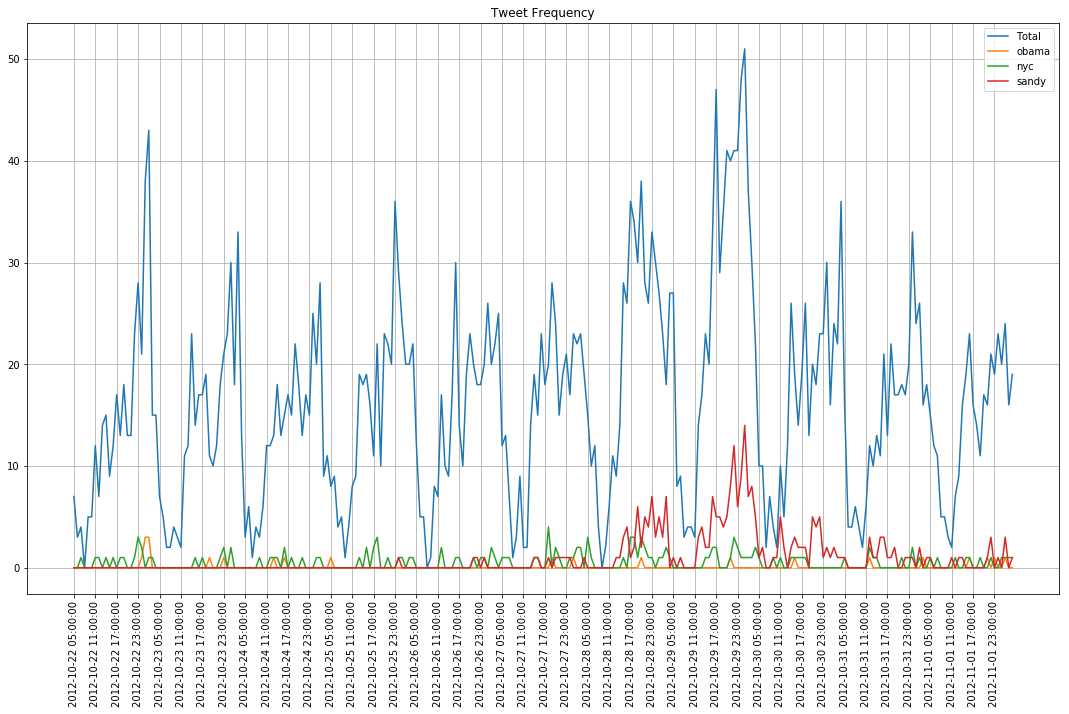

In [17]:
# What keywords are we interested in?
targetKeywords = ["obama", "nyc"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if keyword in tweetString:
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Question 6**. Study some example codes with 2 different hashtags. Explain how are those messages different. 

**Question 7**. Which among the top 20 hashtags are related to Sandy. What are the most popular non-Sandy hashtags? 

**Answer 6**

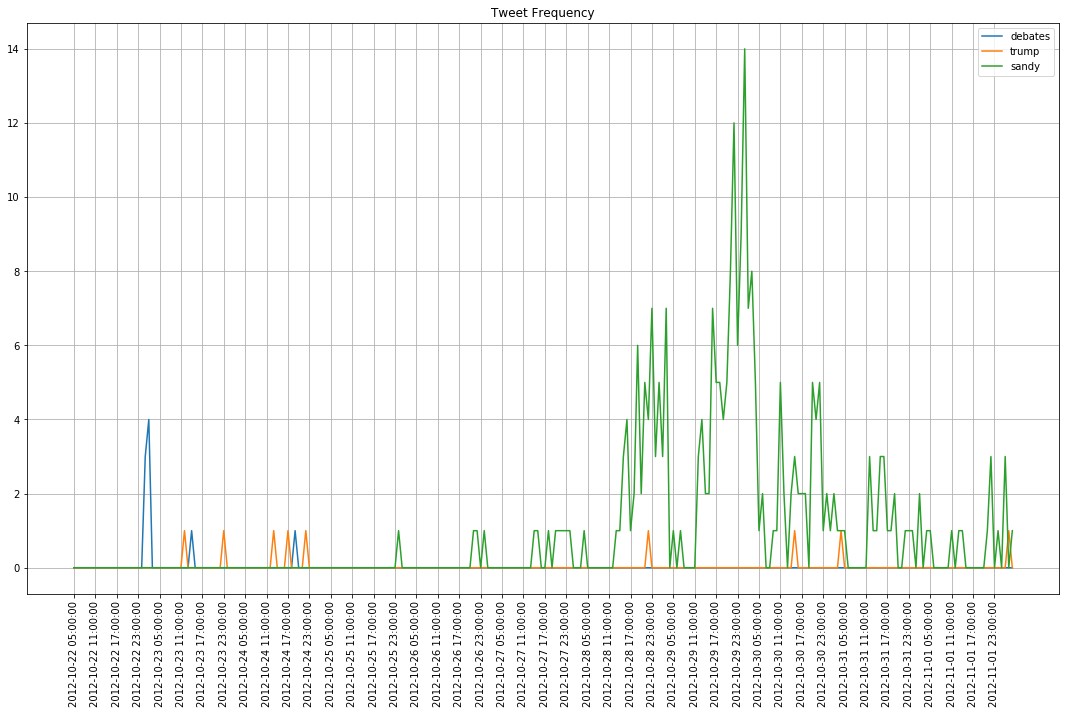

In [18]:
# What keywords are we interested in?
targetKeywords = ["debates", "trump"]
# targetKeywords.append("lowery")
# targetKeywords.append("reilly")
targetKeywords.append("sandy")

# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in targetKeywords}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in targetKeywords}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in targetKeywords:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in targetKeywords:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in targetKeywords:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

The hashtag "#debates" was very popular before Sandy (Sandy happened during the US Election 2012, so that's why). Likewise, "#trump" was very popular (It was the time during which Trump said he intended to run for president). Hashtag "#sandy" reached a peak on October 29/30, the time when sandy "official" hit New York

Let's plot a similar graph for our top 20 hashtags

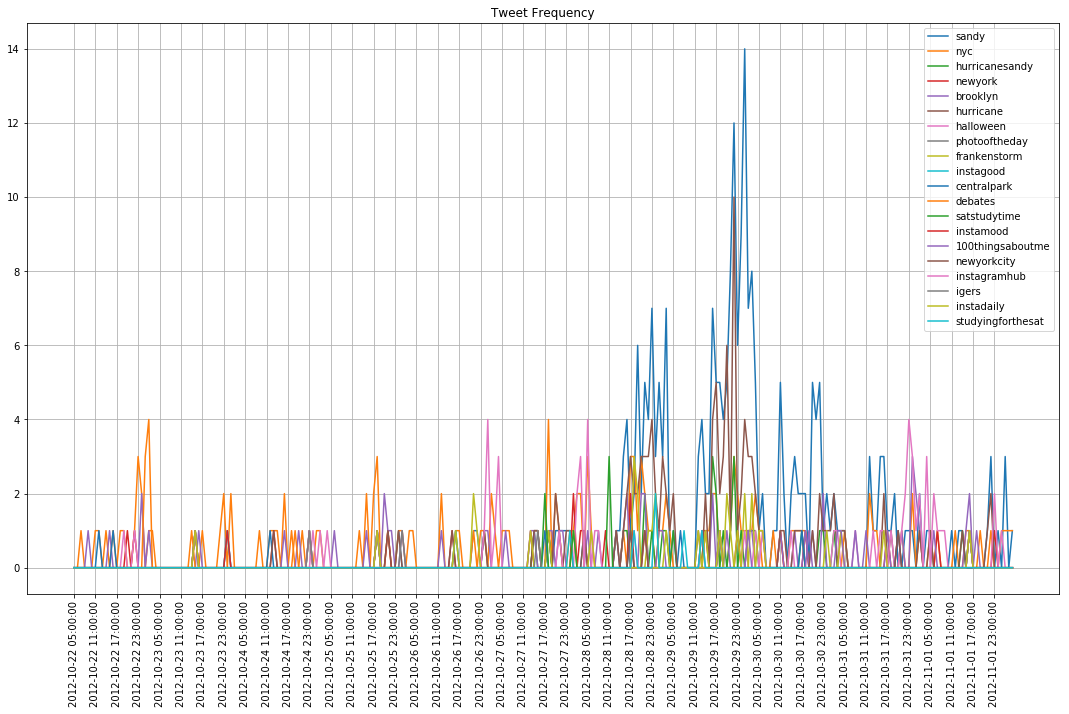

In [19]:
# targetKeywords = ["obama", "nyc"]
# # targetKeywords.append("lowery")
# # targetKeywords.append("reilly")
# targetKeywords.append("sandy")
topHashtags = sortedHashtags[:20]
# Build an empty map for each keyword we are seaching for
targetCounts = {x:[] for x in topHashtags}
totalCount = []

# For each minute, pull the tweet text and search for the keywords we want
for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    # Temporary counter for this minute
    localTargetCounts = {x:0 for x in topHashtags}
    localTotalCount = 0
    
    for tweetObj in timeObj["list"]:
        tweetString = tweetObj["text"].lower()

        localTotalCount += 1
        
        # Add to the counter if the target keyword is in this tweet
        for keyword in topHashtags:
            if ( keyword in tweetString ):
                localTargetCounts[keyword] += 1
                
    # Add the counts for this minute to the main counter
    totalCount.append(localTotalCount)
    for keyword in topHashtags:
        targetCounts[keyword].append(localTargetCounts[keyword])
        
# Now plot the total frequency and frequency of each keyword
fig, ax = plt.subplots()
fig.set_size_inches(18.5,10.5)

plt.title("Tweet Frequency")
plt.xticks(smallerXTicks, [sortedTimes[x] for x in smallerXTicks], rotation=90)

# ax.plot(range(len(frequencyMap)), totalCount, label="Total")


for keyword in topHashtags:
    ax.plot(range(len(frequencyMap)), targetCounts[keyword], label=keyword)
ax.legend()
ax.grid(b=True, which=u'major')

plt.show()

**Answer 7**

* Related to Sandy: ('#sandy', 108), ('hurricanesandy', 26), ('#hurricane', 8), maybe ('#frankenstorm', 8)
* Most popular non-Sandy hashtags: ('#nyc', 47), ('#newyork', 12), ('#brooklyn', 9), ('#halloween', 8), ('#instagood', 8), ('#instagood', 8), ('#centralpark', 7), ('#debates', 6), ('#satstudytime', 6), ('#instagramhub', 5), ('#igers', 5), ('#instadaily', 5), ('#100thingsaboutme', 5), ('#igers', 5)

### Language Distribution

The following code gives an insight into the languages used for the tweets in your data.


In [20]:
# A map for counting each language
languageCounter = {}

for t in sortedTimes:
    timeObj = frequencyMap[t]
    
    for tweet in timeObj["list"]:
        lang = tweet["lang"]
        
        if lang not in languageCounter:
            languageCounter[lang] = 1
        else:
            languageCounter[lang] += 1
            
languages = sorted(languageCounter.keys(), key=languageCounter.get, reverse=True)

for l in languages:
    print(l, languageCounter[l])

(u'en', 3688)
(u'es', 192)
(u'und', 162)
(u'tl', 29)
(u'fr', 27)
(u'pt', 24)
(u'ar', 20)
(u'tr', 20)
(u'ht', 20)
(u'ru', 18)
(u'it', 16)
(u'in', 16)
(u'nl', 6)
(u'de', 6)
(u'ja', 6)
(u'sv', 5)
(u'pl', 4)
(u'fi', 4)
(u'ko', 4)
(u'lv', 3)
(u'ro', 3)
(u'hi', 3)
(u'vi', 2)
(u'is', 2)
(u'cy', 2)
(u'cs', 2)
(u'et', 2)
(u'da', 2)
(u'sl', 2)
(u'zh', 1)
(u'eu', 1)
(u'lt', 1)
(u'fa', 1)
(u'hu', 1)


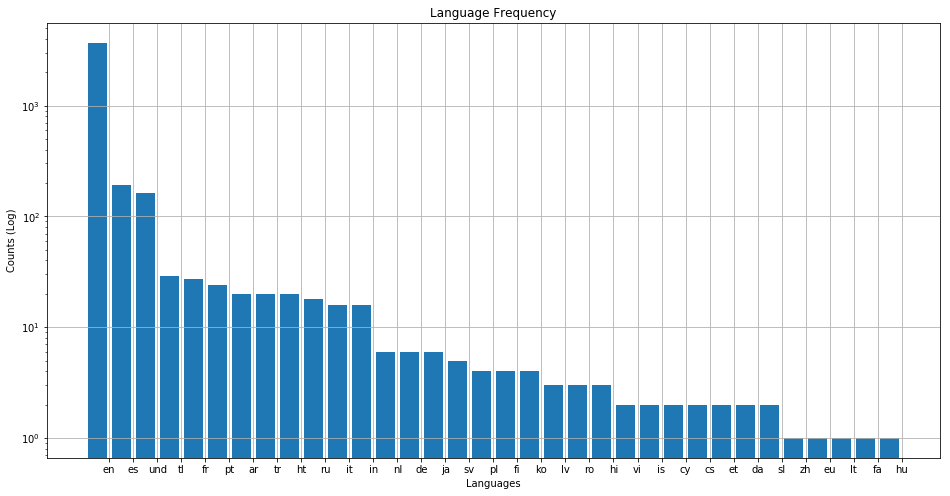

In [21]:
plt.figure(figsize=(16,8))
    
# the histogram of the data
plt.bar(
    np.arange(len(languages)),
    [languageCounter[x] for x in languages],
    log=True)

plt.xticks(np.arange(len(languages)) + 0.5, languages)
plt.xlabel('Languages')
plt.ylabel('Counts (Log)')
plt.title("Language Frequency")
plt.grid(True)

plt.show()

**Quesiton 8**. Now that you have experience in extracting different types of information from twitter data, perform your own EDA. Produce a 1-page report providing some interesting insights about the Sandy twitter data.

## Module 2: Classification

In this part of the lab, we will work on a binary classificaiton problem. In particular, we would like to see how easy it is to discriminate between tweets with hashtag #sandy and the rest of them. To do it, we will first create labels: positive tweets will be those with hashtag #sandy and negative those without the hashtag. Then, we will create a bag-of-words vector out of each tweet, but we will exclude word "#sandy". To produce the bag-of-words representation we will use the `CountVectorizer` functionality 

In [24]:
import pandas as pd
import numpy as np
import codecs, json

"""
Step 1. Create sentences and labels from json file. 
"""
filePath='smallNYC.json'
sents = []
reader = codecs.getreader("utf-8")
for line in open(filePath, 'rb'):
    # Try to read tweet JSON into object
    tweetObj = None
    tweetObj = json.loads(reader.decode(line)[0])
    sents.append(tweetObj['text'])
    
"""
Step 2.1. Get label. If sent contains '#sandy', label=1; otherwise, label=0
"""
labels = np.array(['#sandy' in sent.split() for sent in sents], dtype='int')
print(pd.Series(labels).value_counts())
"""
Step 2.2. Represent the data into Bag-of-words features, i.e, each sentence is a 
            vector of word counts. 
          a). Only select words with frequency >= 5
          b). Remove label words '#sandy'
"""

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, stop_words = ['#sandy'])
features = vectorizer.fit_transform(sents)


print('#sandy' in vectorizer.get_feature_names())
print(features.toarray())
print(vectorizer.get_feature_names())

0    4234
1      61
dtype: int64
False
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[u'00', u'10', u'100thingsaboutme', u'12', u'13', u'14', u'15', u'16', u'18', u'20', u'2012', u'21', u'24', u'26', u'28', u'2nd', u'30', u'40', u'50', u'6th', u'able', u'about', u'actually', u'ads', u'adventure', u'af', u'after', u'afternoon', u'again', u'against', u'ago', u'ain', u'air', u'airport', u'al', u'album', u'alert', u'alive', u'all', u'almost', u'already', u'also', u'always', u'am', u'amazing', u'america', u'american', u'amp', u'an', u'and', u'another', u'any', u'anyone', u'anything', u'anyway', u'apartment', u'apocalypse', u'app', u'apple', u'appreciate', u'aqui', u'are', u'area', u'aren', u'around', u'art', u'as', u'ask', u'asked', u'asleep', u'ass', u'astoria', u'at', u'ave', u'avenue', u'away', u'awesome', u'awkward', u'aww', u'awww', u'babe', u'baby', u'back', u'bacon', u'bad', u'ballroom', u'bar', u'barclays', u'

c:\users\inceptix\documents\github\cis-3715\python2\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['sandy'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


**Quesiton 9**. Given the data set of labeled tweets, you have to train a classification model and check the accuracy. Remember to first split the data into training and test. You should explore kNN classification, decision tree classification, Random Forest classification.

**Question 10**. Train the so-called *Logistic regression classifier* and check its accuracy. Compare with the results from *Question 9*. The following lines of code will be useful to do it.

In [25]:
"""
Step 3. Divide data into train and test 
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42) 
import time
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression(solver='lbfgs')
start_time = time.time()
clf.fit(X_train, y_train)
print('Time for %s fitting: %.3f' % ('LogisticRegression', time.time() - start_time))
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_prob = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_prob)
print('Test Perf ACC: %.3f, AUC: %.3f' %(accuracy, auc))

Time for LogisticRegression fitting: 0.013
Test Perf ACC: 0.989, AUC: 0.986


**Answers 9 and 10**

In [26]:
from sklearn import neighbors
import itertools

In [27]:
Metrics = ['euclidean', 'minkowski', 'cosine']
K = [1,3,5,15,25,50]
Weights = ['uniform', 'distance']
Combo = list(itertools.product(K,Weights, Metrics))
len(Combo)

36

In [28]:
for c in Combo:
    clf = neighbors.KNeighborsClassifier(c[0], weights = c[1], metric = c[2])
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    print 'Time Cost of kNN ', end - start
    print '# k neighbors: %i, weights: %s, metric: %s' % (c[0], c[1], c[2])
    print 'Test Perf ACC: %3f, AUC: %.3f' % (accuracy, auc)

Time Cost of kNN  0.000999927520752
# k neighbors: 1, weights: uniform, metric: euclidean
Test Perf ACC: 0.984485, AUC: 0.621
Time Cost of kNN  0.000999927520752
# k neighbors: 1, weights: uniform, metric: minkowski
Test Perf ACC: 0.984485, AUC: 0.621
Time Cost of kNN  0.000999927520752
# k neighbors: 1, weights: uniform, metric: cosine
Test Perf ACC: 0.982370, AUC: 0.651
Time Cost of kNN  0.000999927520752
# k neighbors: 1, weights: distance, metric: euclidean
Test Perf ACC: 0.984485, AUC: 0.621
Time Cost of kNN  0.000999927520752
# k neighbors: 1, weights: distance, metric: minkowski
Test Perf ACC: 0.984485, AUC: 0.621
Time Cost of kNN  0.000999927520752
# k neighbors: 1, weights: distance, metric: cosine
Test Perf ACC: 0.982370, AUC: 0.651
Time Cost of kNN  0.000999927520752
# k neighbors: 3, weights: uniform, metric: euclidean
Test Perf ACC: 0.983075, AUC: 0.774
Time Cost of kNN  0.00100016593933
# k neighbors: 3, weights: uniform, metric: minkowski
Test Perf ACC: 0.983075, AUC: 0.

Our best result produced by kNN is:
* Time Cost of kNN 0.000999927520752
* #k neighbors: 50, weights: distance, metric: cosine
* Test Perf ACC: 0.988717, AUC: 0.972

It is a little bit worse than Logistic Classifier, but it is way faster!

In [30]:
criterion = ['gini', 'entropy']
max_depth = [5,10,15]
min_samples_leaf = [5,15]
combine = list(itertools.product(criterion,max_depth,min_samples_leaf))
len(combine)

12

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
for c in combine:
    estimator = DecisionTreeClassifier(criterion = c[0], max_depth = c[1], min_samples_leaf = c[2])
    start = time.time()
    estimator.fit(X_train,y_train)
    end = time.time()
    y_pred = estimator.predict(X_test)
    y_pred_prob = estimator.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    print 'Decision Tree Time Cost', end - start
    print "criterion %s, max_depth %i, min_samples_leaf %i" %(c[0], c[1], c[2])
    print "Test Perf ACC: %3f, AUC: %3f" % (accuracy, auc)

Decision Tree Time Cost 0.00100016593933
criterion gini, max_depth 5, min_samples_leaf 5
Test Perf ACC: 0.985896, AUC: 0.989190
Decision Tree Time Cost 0.000999927520752
criterion gini, max_depth 5, min_samples_leaf 15
Test Perf ACC: 0.983780, AUC: 0.987919
Decision Tree Time Cost 0.00200009346008
criterion gini, max_depth 10, min_samples_leaf 5
Test Perf ACC: 0.985896, AUC: 0.988967
Decision Tree Time Cost 0.00200009346008
criterion gini, max_depth 10, min_samples_leaf 15
Test Perf ACC: 0.983780, AUC: 0.987919
Decision Tree Time Cost 0.0019998550415
criterion gini, max_depth 15, min_samples_leaf 5
Test Perf ACC: 0.985896, AUC: 0.988967
Decision Tree Time Cost 0.00200009346008
criterion gini, max_depth 15, min_samples_leaf 15
Test Perf ACC: 0.983780, AUC: 0.987919
Decision Tree Time Cost 0.00200009346008
criterion entropy, max_depth 5, min_samples_leaf 5
Test Perf ACC: 0.983780, AUC: 0.986559
Decision Tree Time Cost 0.00200009346008
criterion entropy, max_depth 5, min_samples_leaf 15
T

Best result produced by Decision Tree is:
* Decision Tree Time Cost 0.00800013542175
* criterion gini, max_depth 5, min_samples_leaf 5
* Test Perf ACC: 0.987306, AUC: 0.990572

Not as fast as k-NN, but better result! This is the best result we have so far

In [33]:
n_estimators = [5,10,15,20]
criterion = ['gini', 'entropy']
max_depth = [5,10,15,20]
min_samples_leaf = [5,10,15]
ForestCom = list(itertools.product(n_estimators, criterion,max_depth,min_samples_leaf))
len(ForestCom)

96

In [34]:
for c in ForestCom:
    clf = RandomForestClassifier(n_estimators = c[0], criterion = c[1], max_depth = c[2], min_samples_leaf = c[3])
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    print "Random Forest Time Cost", end - start
    print '# estimators: %i, criterion: %s, max_depth: %s, min_samples_leaf: %i' % (c[0], c[1], c[2], c[3])
    print 'Test perf ACC: %3f, AUC: %.3f' % (accuracy, auc)
    print '\n'

Random Forest Time Cost 0.00799989700317
# estimators: 5, criterion: gini, max_depth: 5, min_samples_leaf: 5
Test perf ACC: 0.988717, AUC: 0.983


Random Forest Time Cost 0.0540001392365
# estimators: 5, criterion: gini, max_depth: 5, min_samples_leaf: 10
Test perf ACC: 0.988717, AUC: 0.986


Random Forest Time Cost 0.00799989700317
# estimators: 5, criterion: gini, max_depth: 5, min_samples_leaf: 15
Test perf ACC: 0.988717, AUC: 0.660


Random Forest Time Cost 0.00799989700317
# estimators: 5, criterion: gini, max_depth: 10, min_samples_leaf: 5
Test perf ACC: 0.988717, AUC: 0.930


Random Forest Time Cost 0.00800013542175
# estimators: 5, criterion: gini, max_depth: 10, min_samples_leaf: 10
Test perf ACC: 0.988717, AUC: 0.690


Random Forest Time Cost 0.00799989700317
# estimators: 5, criterion: gini, max_depth: 10, min_samples_leaf: 15
Test perf ACC: 0.988717, AUC: 0.983


Random Forest Time Cost 0.00799989700317
# estimators: 5, criterion: gini, max_depth: 15, min_samples_leaf: 5
Te

Random Forest Time Cost 0.0259997844696
# estimators: 15, criterion: gini, max_depth: 15, min_samples_leaf: 10
Test perf ACC: 0.988717, AUC: 0.991


Random Forest Time Cost 0.021999835968
# estimators: 15, criterion: gini, max_depth: 15, min_samples_leaf: 15
Test perf ACC: 0.988717, AUC: 0.989


Random Forest Time Cost 0.0249998569489
# estimators: 15, criterion: gini, max_depth: 20, min_samples_leaf: 5
Test perf ACC: 0.988717, AUC: 0.989


Random Forest Time Cost 0.0229997634888
# estimators: 15, criterion: gini, max_depth: 20, min_samples_leaf: 10
Test perf ACC: 0.988717, AUC: 0.988


Random Forest Time Cost 0.0220000743866
# estimators: 15, criterion: gini, max_depth: 20, min_samples_leaf: 15
Test perf ACC: 0.988717, AUC: 0.991


Random Forest Time Cost 0.0220000743866
# estimators: 15, criterion: entropy, max_depth: 5, min_samples_leaf: 5
Test perf ACC: 0.988717, AUC: 0.985


Random Forest Time Cost 0.0209999084473
# estimators: 15, criterion: entropy, max_depth: 5, min_samples_lea

Random Forest is more costly than Decision Tree. The result is slightly better!

In [35]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

In [36]:
loss = ['deviance', 'exponential']
max_depth = [2,3]
estimators = [100,150]
GradientCombo = list(itertools.product(loss,estimators,max_depth))

In [37]:
for c in GradientCombo:
    clf = GBC(loss = c[0], n_estimators = c[1], max_depth = c[2])
    start = time.time()
    clf.fit(X_train,y_train)
    end = time.time()
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    print 'loss: %s, # estimators: %i, max_depth: %i' % (c[0], c[1], c[2])
    print 'Gradient Boosting Tree Time Cost', end - start
    print 'accuracy = %3f, AUC = %.3f' % (accuracy, auc)

loss: deviance, # estimators: 100, max_depth: 2
Gradient Boosting Tree Time Cost 0.12700009346
accuracy = 0.987306, AUC = 0.988
loss: deviance, # estimators: 100, max_depth: 3
Gradient Boosting Tree Time Cost 0.160999774933
accuracy = 0.985896, AUC = 0.987
loss: deviance, # estimators: 150, max_depth: 2
Gradient Boosting Tree Time Cost 0.188999891281
accuracy = 0.986601, AUC = 0.989
loss: deviance, # estimators: 150, max_depth: 3
Gradient Boosting Tree Time Cost 0.25400018692
accuracy = 0.985896, AUC = 0.986
loss: exponential, # estimators: 100, max_depth: 2
Gradient Boosting Tree Time Cost 0.131999969482
accuracy = 0.988011, AUC = 0.987
loss: exponential, # estimators: 100, max_depth: 3
Gradient Boosting Tree Time Cost 0.153000116348
accuracy = 0.986601, AUC = 0.988
loss: exponential, # estimators: 150, max_depth: 2
Gradient Boosting Tree Time Cost 0.1890001297
accuracy = 0.985896, AUC = 0.987
loss: exponential, # estimators: 150, max_depth: 3
Gradient Boosting Tree Time Cost 0.253000

Gradient Boosting Tree is the most costly algorithm so far. The result is slightly better than Decision Tree, but not as good as Random Forest

* In terms of computational time: kNN > Decision Tree > Logistic Regression > Random Forest > Gradient Boosting Tree ('>' means better)
* In general, all algorithms produce good results. Random Forest, Gradient Boosting Tree are the best, Decision Tree and Logistic Regression are only very slightly worse (but still very good), kNN doesn't produce results at equal quality as other algorithms.